<a href="https://colab.research.google.com/github/dpshepherd/PHY452_F2023/blob/main/HW10_off_axis_hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unmixing off-axis hologram data

# Exercise goal
The goal of this exercise is to unmix the off-axis digital hologram image that you have been provided.

# Experiment background

You have been provided an off-axis hologram image of a [$10 \mu m$ polystyrene microsphere](https://www.thermofisher.com/order/catalog/product/F8836) embedded in microscopy oil ($n=1.5$) between two glass coverslips ($n=1.515$). The laser source is a [stabilized $785$ nm laser diode](https://www.thorlabs.com/thorproduct.cfm?partnumber=FPL785P). The incident beam k-vector lies along the optical axis and the angle of the off-axis reference beam, with respect to the optical axis, is unknown.

The camera is has a pixel size of $10 \mu m$ and the imaging system has an overall imaging magnfication of $100\times$, yielding an effective pixel size of $0.1 \mu m$. The detection objective is a water immersion model with $NA = 1.0$.

# Theory background

Building on our previous lectures, we know that the electric field, $E(x,y)$ at the plane of interference (the camera sensor) is given by,

$|E(x,y)|^2 = |R(x,y)|^2 + |O(x,y)|^2 + O^*(x,y)R(x,y) + O(x,y)R^*(x,y)$,

with $R$ denoting the reference field and $O$ denoting the object field.

It is useful to think about the real space and reciprocal space configuration just before the camera (see class notes).

Generally, we try to satisfy $\alpha_{max} \sim \frac{\lambda}{2 \Delta x}$, where $\Delta x$ is the effective camera pixel spacing. This ensure that all of the holographic data is contained within the accessible frequency space given the discrete pixel sizes.

It is easiest to unmix the holograms in the Fourier domain,

$\mathcal{F}[|E(x,y)|^2] = \mathcal{F}[|R(x,y)|^2 + |O(x,y)|^2] + \mathcal{F}[O^*(x,y)R(x,y)] + \mathcal{F}[O(x,y)R^*(x,y)]$.

Remember that $R(x,y) = E_Re^{-i\vec{k}_R \cdot \vec{r}}$, which we can plug into the terms we are interested in above to give ($\ast$ denotes convolution),

$\mathcal{F}[O^*(x,y)R(x,y)] = \tilde{O}(\vec{k})^* \ast \mathcal{F}[E_Re^{+i\vec{k}_R \cdot \vec{r}}] $,

and

$\mathcal{F}[O(x,y)R^*(x,y)] = \tilde{O}(\vec{k}) \ast \mathcal{F}[E_Re^{-i\vec{k}_R \cdot \vec{r}}] $.

These contain redundant information, so we will just focus on the second equation. Pratically, it will be fine for unmixing.

From HW #4-5 and our practice with the Fourier shift thm., we know that that $\mathcal{F}[E_Re^{+i\vec{k}_R \cdot \vec{r}}] = \delta (\vec{k}+\vec{k}_R)$, yielding,

$\mathcal{F}[O(x,y)R^*(x,y)] = \tilde{O}(\vec{k}) \ast \delta (\vec{k}+\vec{k}_R)] = \tilde{O}(\vec{k}+\vec{k}_R)$.

The quantity we are interested in is $\tilde{O}(\vec{k})$, which means we need to use the shift thm. and the known reference frequencies to shift back.

$\tilde{O}(k) = \tilde{O}(\vec{k}+\vec{k}_R) \ast \mathcal{F}[E_Re^{-i\vec{k}_R \cdot \vec{r}}]$.

That means from our data, we need to:
1. Find and isolate the area of the digital hologram in reciprocal space that corresponds to $\mathcal{F}[O(x,y)R^*(x,y)]$.
2. Find the reference frequency, $\vec{k}_R$.
3. Use the Fourier shift thm. to shift the digital hologram in reciprocal space.
4. Take the inverse discrete Fourier Transform to obtain the electric fields that correspond to the incident + scattered field from the object.


# Computational approach

### load Python computational and plotting libraries

In [1]:
!pip install tifffile

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from google.colab import files
from tifffile import imread

### Load the raw off-axis hologram.

In [3]:
dict_files = files.upload()

Saving PHY452_F2023_hologram.tif to PHY452_F2023_hologram (3).tif


Copy the name that Google saved the file into and paste inside the single quotes below.

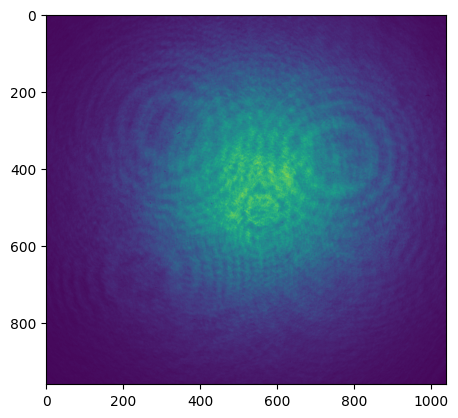

In [4]:
raw_data = imread('PHY452_F2023_hologram (3).tif')
plt.imshow(raw_data)
plt.show()

### Create spatial coordinates using pixel spacing with center pixel corresponding to $(x=0,y=0)$.

Remember that python ordering is yx for this array.

In [11]:
camera_pixel_size = 0.1 # microns
x_axis = np.arange(-raw_data.shape[1]/2,raw_data.shape[1]/2)*camera_pixel_size
y_axis = np.arange(-raw_data.shape[0]/2,raw_data.shape[0]/2)*camera_pixel_size

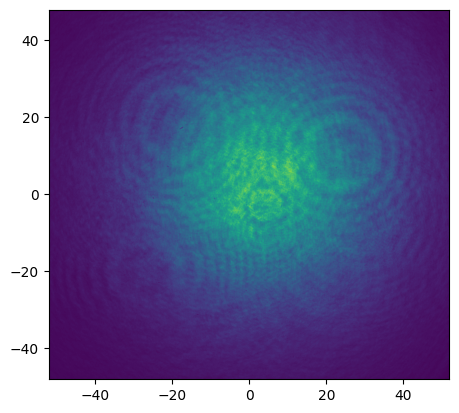

In [12]:
plt.imshow(raw_data,
           extent = (x_axis[0],x_axis[-1],y_axis[0],y_axis[-1]))
plt.show()

### Calculate discrete Fourier Transform using [numpy.fft](https://numpy.org/doc/stable/reference/routines.fft.html).

In [22]:
img_fft = np.fft.fftshift(np.fft.fft2(raw_data))

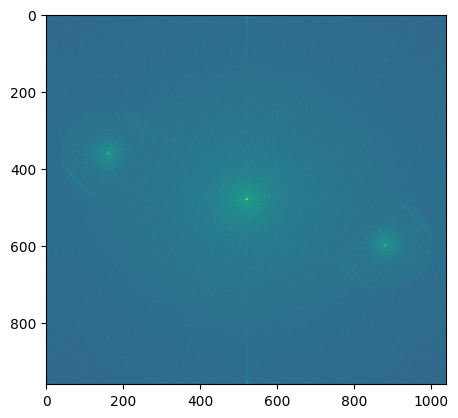

In [30]:
plt.imshow(np.abs(img_fft),norm=colors.PowerNorm(gamma=0.1))
plt.show()

### Ensure center pixel of FFT corresponds to $(k_x=0,k_y=0)$ and the pixel spacing is correct in reciprocal space.

In [31]:
# you need to figure out how to use this correctly for f_x and f_y
f_x = np.fft.fftshift(np.fft.fftfreq(raw_data.shape[0],d=camera_pixel_size))

array([-5.        , -4.98958333, -4.97916667, -4.96875   , -4.95833333,
       -4.94791667, -4.9375    , -4.92708333, -4.91666667, -4.90625   ,
       -4.89583333, -4.88541667, -4.875     , -4.86458333, -4.85416667,
       -4.84375   , -4.83333333, -4.82291667, -4.8125    , -4.80208333,
       -4.79166667, -4.78125   , -4.77083333, -4.76041667, -4.75      ,
       -4.73958333, -4.72916667, -4.71875   , -4.70833333, -4.69791667,
       -4.6875    , -4.67708333, -4.66666667, -4.65625   , -4.64583333,
       -4.63541667, -4.625     , -4.61458333, -4.60416667, -4.59375   ,
       -4.58333333, -4.57291667, -4.5625    , -4.55208333, -4.54166667,
       -4.53125   , -4.52083333, -4.51041667, -4.5       , -4.48958333,
       -4.47916667, -4.46875   , -4.45833333, -4.44791667, -4.4375    ,
       -4.42708333, -4.41666667, -4.40625   , -4.39583333, -4.38541667,
       -4.375     , -4.36458333, -4.35416667, -4.34375   , -4.33333333,
       -4.32291667, -4.3125    , -4.30208333, -4.29166667, -4.28

### Determine reference beam frequency ($k_R$).

### Clear data outside of desired off-axis component (either $\mathcal{F}[O^*R]$ or $\mathcal{F}[OR^*]$).

### Use Fourier shift thm. to recover $\tilde{O}(k_x,k_y)$.


### Finally, use the inverse FFT to recover $O(x,y)$.

### Does $O(x,y)$ match your expectations? What more can you learn about the object based on what we have done in class?